# AFL Match Predictors

In [1]:
from matplotlib import pyplot as plt
import json
plt.style.use(['mvstyle', 'one_piece'])

import numpy as np
import requests
import pandas as pd
from os.path import isfile
from glob import glob
import re
import os

## Data Processing 

In [30]:
years = np.arange(1970, 2025)
headers = {'User-Agent':'MV_tipping_predictions'}

for year in years:

    if isfile(f'Seasonal_Data/data_{year:d}.csv'):

        # print('Data already downloaded.')
        
        continue

    response = requests.get(f'https://api.squiggle.com.au/?q=games;year={year:d};format=csv', headers=headers)

    with open(f'Seasonal_Data/data_{year:d}.csv', 'w') as f:
        f.write(response.text)

Get the standings for each round

In [31]:
rounds = np.arange(1, 29)

for year in years:
    try:
        os.mkdir(f'Standings/{year:d}/')
    except:
        pass
    for round_ in rounds:

        if isfile(f'Standings/{year:d}/round_{round_:d}.csv'):

            # print('Data already downloaded.')
            
            continue
        
        response = requests.get(f'https://api.squiggle.com.au/?q=standings;year={year:d};round={round_};format=csv', headers=headers)

        with open(f'Standings/{year:d}/round_{round_:d}.csv', 'w') as f:
            f.write(response.text)

In [32]:
# Some helper functions for use later

def get_year(file):
    
    file = re.sub('^Seasonal_Data/data_', '', file)    
    file = file.rstrip('.csv')

    return int(file)

def get_round(file):
    
    file = re.sub('^Standings/\w+/round_', '', file)    
    file = file.rstrip('.csv')

    return int(file)

def read_ranking(file):

    _round = get_round(file)

    _df  = pd.read_csv(file)

    _df.insert(loc=0, column='round', value=_round * np.ones(len(_df), dtype= int))

    return _df


In [33]:
# Function to read in ranking, number of wins and number of losses
# for each team for each round

def standings_data(year):
    rank_files = glob(f'Standings/{year:d}/*')

    standings_frame = pd.concat(read_ranking(file) for file in rank_files)

    # Fill NaN values for rank in finals rounds with the mean of the 
    # team's rank # throughout the season
    standings_frame['rank'] = standings_frame['rank'].fillna(
        standings_frame.groupby('id')['rank'].transform('mean')
        )

    standings_frame = standings_frame[['round', 'id', 'rank', 'wins','losses']]
    standings_frame = standings_frame.sort_values('round')
    standings_frame = standings_frame.reset_index(drop=True)

    return standings_frame

In [34]:
def merge_standings(main_data, standings_data):

    lookup = standings_data[['round', 'id', 'rank', 'wins', 'losses']]

    # Merge with standings_data to filter matching rows
    for prefix in ['h', 'a']:

        filtered_main_data = main_data.merge(lookup, left_on=['round', f'{prefix}teamid'], right_on=['round', 'id'], how='inner')
        filtered_main_data = filtered_main_data.rename(columns= {'rank':f'{prefix}rank', 'wins': f'{prefix}wins', 'losses': f'{prefix}losses'})
        main_data = filtered_main_data.drop('id', axis=1)

    return main_data


Team info to tranlate ID and team name

In [35]:
team_data = requests.get('https://api.squiggle.com.au/?q=teams;format=csv', headers=headers)

with open('team_data.csv', 'w') as f:
    f.write(team_data.text)

In [36]:
team_data = pd.read_csv('team_data.csv', index_col=None)
# team_dict = team_data[['name', 'id']].to_dict('index')
names = team_data['name'].to_numpy()
ids = team_data['id'].to_numpy()

team_dict = {id_ : name for id_, name in zip(ids, names)}


Create a function to process the raw data into the statistics we want

In [37]:
def process_season_data(datafile):

    # Select relevant columns

    dataframe = pd.read_csv(datafile)

    dataframe = dataframe[['round', 'hteamid', 'ateamid', 'hscore', 
                           'ascore', 'hgoals', 'agoals', 'hbehinds', 
                           'abehinds', 'is_final', 'winnerteamid']].copy()

    # Fill NaN values in winnerteamid
    dataframe['winnerteamid'] = dataframe['winnerteamid'].fillna(0)

    # Compute hteamwin using np.where()
    dataframe['hteamwin'] = np.where(
        dataframe['winnerteamid'] == 0, 2, 
        np.where(dataframe['winnerteamid'] == dataframe['hteamid'], 1, 0)
    )



    # Compute expanding mean for each team using groupby()
    column_team_mapping = { 
        'hscore': 'hteamid', 'hgoals': 'hteamid', 'hbehinds': 'hteamid', 
        'ascore': 'ateamid', 'agoals': 'ateamid', 'abehinds': 'ateamid' 
        }

    # Compute expanding means efficiently in a single loop
    for col, team_col in column_team_mapping.items():
        dataframe[f'{col}_ppg'] = (
            dataframe.groupby(team_col)[col]
            .expanding().mean()
            .reset_index(level=0, drop=True)
        )
    
    year = get_year(datafile)
    dataframe = merge_standings(dataframe, standings_data(year))

    # Select final columns
    final_data = dataframe[['round', 
                            'hteamid', 'ateamid',
                            'hrank', 'arank', 
                            'hscore_ppg', 'ascore_ppg', 
                            'hgoals_ppg', 'agoals_ppg', 
                            'hbehinds_ppg', 'abehinds_ppg', 
                            'hwins', 'awins', 
                            'hlosses', 'alosses',  
                            'is_final', 'hteamwin']].copy()
    
    
    return final_data

Combine all seasonal data into one DataFrame

In [38]:
data_files = glob('Seasonal_Data/data_*.csv')
full_data = pd.concat(process_season_data(file) for file in data_files)
full_data.__len__()

9476

## Neural Nets

### Process data for use in neural nets

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

In [40]:
class PandasDataset(Dataset):

    def __init__(self, dataframe):
        self.data = dataframe.drop(columns=['hteamwin']).values  # Features
        self.labels = dataframe['hteamwin'].values.astype(np.int16)  # Targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

In [73]:
main_data = PandasDataset(full_data)


train_proportion = 0.7
val_proportion = 1.0 - train_proportion

batch_size = 100

train_data, val_data = train_test_split(main_data, train_size=train_proportion, shuffle=True, random_state=42)

train_loader = DataLoader(train_data, 
                          shuffle=True, 
                          num_workers=2, 
                          batch_size=batch_size
                          )

val_loader = DataLoader(val_data, 
                        shuffle=True, 
                        num_workers=2, 
                        batch_size=batch_size
                        )

Test speed of data loader

In [74]:
import time
tstart=time.time()
num_iter=100
ctr=num_iter
for batch in train_loader:
    ctr -=100
    if ctr <= 0: break
print((time.time()-tstart)/num_iter,'[s/iteration]')

0.0007592058181762696 [s/iteration]


### Dense Neural Net

Define the neural network architecture

In [88]:
hidden_nodes = 24
output_nodes = 3

class DenseNN(nn.Module):
    def __init__(self,inputNum):

        super(DenseNN, self).__init__()
        
        self.inputNum=inputNum
        
        self.fc1 = nn.Linear(in_features=inputNum, out_features=hidden_nodes)  # Input layer
        self.fc2 = nn.Linear(in_features=hidden_nodes, out_features=hidden_nodes)     # Hidden layer
        self.fc3 = nn.Linear(in_features=hidden_nodes, out_features=hidden_nodes)     # Hidden layer
        self.fc4 = nn.Linear(in_features=hidden_nodes, out_features=hidden_nodes)     # Hidden layer
        # self.fc5 = nn.Linear(in_features=hidden_nodes, out_features=hidden_nodes)     # Hidden layer
        self.fc5 = nn.Linear(in_features=hidden_nodes, out_features=output_nodes)     # Output layer

    def forward(self, x):
        
        x = x.view(-1, self.inputNum)   # Flatten the input
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        # x = torch.relu(self.fc5(x))
        x = self.fc5(x)

        return functional.softmax(x, dim=1)

In [89]:
input_num = main_data[0][0].__len__()
model = DenseNN(input_num)


# # Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):

  print("In epoch: ", epoch)
  
  running_loss_train = []
  running_loss_val = []
  
  index = 0
  
  for batch in train_loader:
      
      index = index + 1
      inputs, labels = batch
      # labels = labels.view(-1, 1) 
      optimizer.zero_grad()
      # print(labels)

      # Forward propagation
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      
      # Backward propagation and optimize
      loss.backward()
      optimizer.step()
      running_loss_train.append(loss.item())

      if index % 10 == 9:    # Print every 100 mini-batches
        print("batch: ", index, " loss = " , np.mean(np.asarray(running_loss_train)))

  print("End train epoch, mean loss: ", np.mean(np.asarray(running_loss_train)))
  index = 0
  for batch in val_loader:
      index = index+1
      inputs, labels = batch
      # labels = labels.view(-1, 1) 
      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      running_loss_val.append(loss.item())
      if index % 10 == 9:    # Print every 100 mini-batches
        print("batch: ", index, " loss = " , np.mean(np.asarray(running_loss_val)))

  print("End val epoch, mean loss: ", np.mean(np.asarray(running_loss_val)))

print('Finished Training')

In epoch:  0
batch:  9  loss =  1.0446126129892137
batch:  19  loss =  0.9953928213370474
batch:  29  loss =  0.966625505480273
batch:  39  loss =  0.9461510532941574
batch:  49  loss =  0.9269329297299288
batch:  59  loss =  0.908940128350662
End train epoch, mean loss:  0.8958645240584416
batch:  9  loss =  0.79226463370853
batch:  19  loss =  0.7887115102065237
batch:  29  loss =  0.7892618035448009
End val epoch, mean loss:  0.7892618035448009
In epoch:  1
batch:  9  loss =  0.792822003364563
batch:  19  loss =  0.7983236657945734
batch:  29  loss =  0.7921648950412356
batch:  39  loss =  0.7898661769353427
batch:  49  loss =  0.7889240104324964
batch:  59  loss =  0.7861069481251604
End train epoch, mean loss:  0.7817924734371812
batch:  9  loss =  0.7917690144644843
batch:  19  loss =  0.774197939195131
batch:  29  loss =  0.7731948947084362
End val epoch, mean loss:  0.7731948947084362
In epoch:  2
batch:  9  loss =  0.7791112330224779
batch:  19  loss =  0.7725295079381842
batc

Model working at 78.9% accuracy


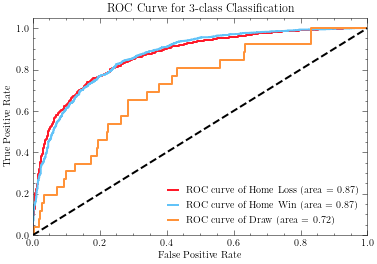

In [90]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_target = []
y_pred = []
for batch in val_loader:
      
      inputs, labels = batch
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      numpy_array = outputs.detach().numpy()
      y_target.extend(labels.numpy())
      y_pred.extend(numpy_array)


y_target = np.array(y_target)  # Example true labels
y_pred = np.array(y_pred)

pred_vals = [x.argmax() for x in y_pred]
mask = pred_vals == y_target
accuracy = mask.sum()/len(mask) * 100
print(f'Model working at {accuracy:0.1f}% accuracy')


target_labels = ["Home Loss", "Home Win", "Draw"]

def plot_roc_curve(y_true, y_pred_prob):

    # Binarize the labels
    y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])

    column_sums = np.sum(y_true_binarized, axis=0)
    # print(column_sums)
    # print(y_true_binarized)
    # print(y_pred_prob)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(target_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure()
    # colors = ['blue', 'red', 'green', 'orange']
    for i in range(len(target_labels)):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label='ROC curve of {0} (area = {1:0.2f})'
                 ''.format(target_labels[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for 3-class Classification')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(y_target, y_pred)

Save the trained model for later use

In [91]:
torch.save(model.state_dict(), 'AFL_prediction_model_DNN.pth')

Load the saved model

In [92]:
model = DenseNN(16)
model.load_state_dict(torch.load('AFL_prediction_model_DNN.pth', weights_only=True))

<All keys matched successfully>

### Convolutional Neural Net

In [ ]:
hidden_nodes = 8
output_nodes = 3

class ConvNN(nn.Module):

    def __init__(self):
        super(ConvNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=2, kernel_size=2, stride=1, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)  # Max pooling layer
        self.conv2 = nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)  # Max pooling layer
        self.conv3 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=2, stride=1, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)  # Max pooling layer
        self.fc = nn.Linear(in_features=8 * 24 * 24, out_features=4)  # Adjusted input size

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)  # Max pooling
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)  # Max pooling
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)  # Max pooling
        # x = x.view(-1, 8 * 24 * 24)  # Adjusted input size
        x = self.fc(x)
        return functional.softmax(x, dim=1)


model = ConvNN()

In [ ]:
model = ConvNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)